# Model stacking

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Попробуем обучить модель на текущем датасете.

In [10]:
df = pd.read_csv('../../full-data/full_processed.csv')

num_feats = ['year','mileage','engine_capacity','engine_power','travel_distance']
cat_feats = ['title','transmission','body_type','drive_type','color','fuel_type']

In [11]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats),
])

base_models = [
    ('cat', CatBoostRegressor(verbose=0, random_seed=42)),
    ('xgb', xgb.XGBRegressor(tree_method='hist', verbosity=0, random_state=42)),
    ('lgb', lgb.LGBMRegressor(random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
]

stack = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

model = Pipeline([
    ('pre', preprocessor),
    ('stack', stack),
])

ДЛя начала возьмём только 10к строк из датасета (позже объясню, зачем это нужно).

In [10]:
def get_dataset_cut(size : int):
  X = df.drop('price', axis=1)
  y = df['price'].values

  return X[:size], y[:size]

In [14]:
X, y = get_dataset_cut(10000)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'mileage',
                                                   'engine_capacity',
                                                   'engine_power',
                                                   'travel_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['title', 'transmission',
                                                   'body_type', 'drive_type',
                                                   'color', 'fuel_type'])])),
                ('stack',
                 StackingRegressor(cv=5,
                                   estimators=[('cat',
                                                <catboost...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('lgb',
                                                LGBMRegressor(random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(random_state=42))],
                                   final_estimator=RidgeCV(), n_jobs=-1,
                                   passthrough=True))])

In [18]:
def print_model_loss(model, X_train, y_train, X_test, y_test):
  preds_train = model.predict(X_train)
  print("MSE train:", mean_squared_error(y_train, preds_train))
  print("MAE train:", mean_absolute_error(y_train, preds_train))
  print("R2 train:", r2_score(y_train, preds_train))

  preds = model.predict(X_test)
  print("MSE:", mean_squared_error(y_test, preds))
  print("MAE:", mean_absolute_error(y_test, preds))
  print("R2:", r2_score(y_test, preds))

In [17]:
print_model_loss(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE train: 466780312740.7382
MAE train: 253612.50961811023
R2 train: 0.2460854281104109
MSE: 493255196874.651
MAE: 295814.7807627032
R2: 0.292116575826166


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Попробуем добавить данных.

In [20]:
X, y = get_dataset_cut(25000)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'mileage',
                                                   'engine_capacity',
                                                   'engine_power',
                                                   'travel_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['title', 'transmission',
                                                   'body_type', 'drive_type',
                                                   'color', 'fuel_type'])])),
                ('stack',
                 StackingRegressor(cv=5,
                                   estimators=[('cat',
                                                <catboost...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('lgb',
                                                LGBMRegressor(random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(random_state=42))],
                                   final_estimator=RidgeCV(), n_jobs=-1,
                                   passthrough=True))])

In [22]:
print_model_loss(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE train: 76856051830.75528
MAE train: 109636.23330167496
R2 train: 0.8346674521597026


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE: 191762284679.27588
MAE: 172039.75111287503
R2: 0.6000905468346485


Наблюдаемый значительное улучшение качества модели и на train и на test. Однако, на train R^2 значительно больше, что может свидетельствовать о переобучении. Добавим ещё данных.

In [18]:
X, y = get_dataset_cut(100000)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
model.fit(X_train, y_train)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

Модель не обучается за адекватное для этого количества данных время и падает после использования всей оперативной памяти. Так быть не должно, попробуем провести Feature Engeneering.

In [12]:
df = pd.read_csv("../../full-data/full_processed.csv", index_col=0)

Возраст - более понятный и выразительный признак. Стабилизируем `miliage`, логорифмируя его, удалим редко встречающиеся бренды убрав "взрыв кардинальности".

In [13]:
df["age"] = 2025 - df["year"]
df["log_mileage"] = np.log1p(df["mileage"])
df["brand"] = df["title"].str.split().str[0]
brand_counts = df["brand"].value_counts()
small_brands = brand_counts[brand_counts < 50].index
df["brand"] = df["brand"].replace(small_brands, "Other")

In [14]:
num_feats = ["age", "log_mileage", "engine_capacity", "engine_power"]
cat_feats = ["transmission", "drive_type", "fuel_type", "brand"]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats),
])

model = Pipeline([
    ('pre', preprocessor),
    ('stack', stack),
])

In [12]:
X, y = get_dataset_cut(10000)

X = X[["age", "log_mileage", "engine_capacity", "engine_power", "transmission", "drive_type", "fuel_type", "brand"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'log_mileage',
                                                   'engine_capacity',
                                                   'engine_power']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['transmission', 'drive_type',
                                                   'fuel_type', 'brand'])])),
                ('stack',
                 StackingRegressor(cv=5,
                                   estimators=[('cat',
                                                <catboost.core.CatBoostRegressor object at 0x78...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('lgb',
                                                LGBMRegressor(random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(random_state=42))],
                                   final_estimator=RidgeCV(), n_jobs=-1,
                                   passthrough=True))])

In [14]:
print_model_loss(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE train: 130085231936.13884
MAE train: 154899.87823033042
R2 train: 0.7898944122804846
MSE: 313726102392.02075
MAE: 234636.86219123667
R2: 0.5497634712799363


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Модель обучилась значительно быстрее, показав хороший результат! Добавим данных.

In [15]:
X, y = get_dataset_cut(100000)

X = X[["age", "log_mileage", "engine_capacity", "engine_power", "transmission", "drive_type", "fuel_type", "brand"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'log_mileage',
                                                   'engine_capacity',
                                                   'engine_power']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['transmission', 'drive_type',
                                                   'fuel_type', 'brand'])])),
                ('stack',
                 StackingRegressor(cv=5,
                                   estimators=[('cat',
                                                <catboost.core.CatBoostRegressor object at 0x78...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('lgb',
                                                LGBMRegressor(random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(random_state=42))],
                                   final_estimator=RidgeCV(), n_jobs=-1,
                                   passthrough=True))])

In [17]:
print_model_loss(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE train: 46997572462154.02
MAE train: 4970723.903853727
R2 train: -104.56502935386109


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE: 48972864612081.08
MAE: 5013558.716672436
R2: -94.1181949580055


In [15]:
X = df.drop('price', axis=1)
y = df['price'].values

X = X[["age", "log_mileage", "engine_capacity", "engine_power", "transmission", "drive_type", "fuel_type", "brand"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'log_mileage',
                                                   'engine_capacity',
                                                   'engine_power']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['transmission', 'drive_type',
                                                   'fuel_type', 'brand'])])),
                ('stack',
                 StackingRegressor(cv=5,
                                   estimators=[('cat',
                                                <catboost.core.CatBoostRegressor object at 0x7c...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('lgb',
                                                LGBMRegressor(random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(random_state=42))],
                                   final_estimator=RidgeCV(), n_jobs=-1,
                                   passthrough=True))])

In [ ]:
print_model_loss(model, X_train, y_train, X_test, y_test)

(У меня кончаются мощности в Colab и не хочется терять сессию после выбивания оперативки, я этот эксперимент уже проводил в другом блокноте, тут будут результаты)
Test для полного датасета:
- ***MSE:*** 2.2111355020406132e+16
- ***MAE:*** 98516466.25876448
- ***R2:*** -4311.81602774809

Чуть внимательнее посмотрим на данные по цене и поймём, что в процессе исследования данных мы ни каким образом не обработали её значения.

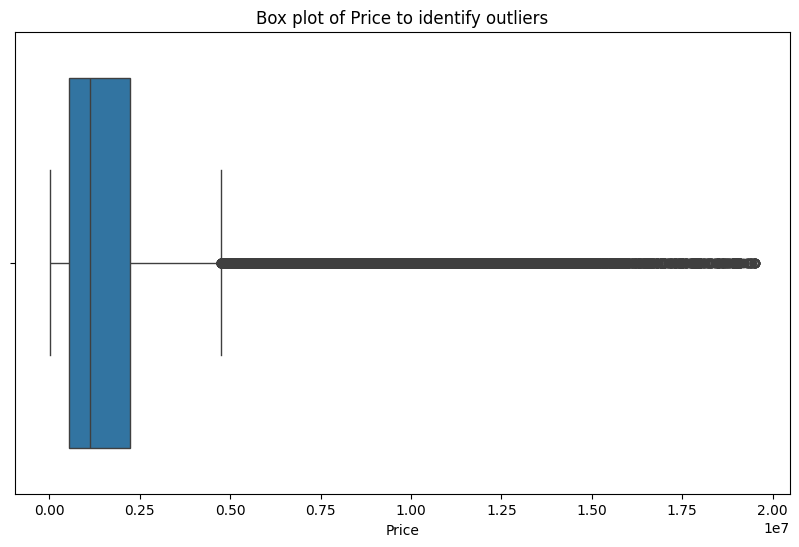

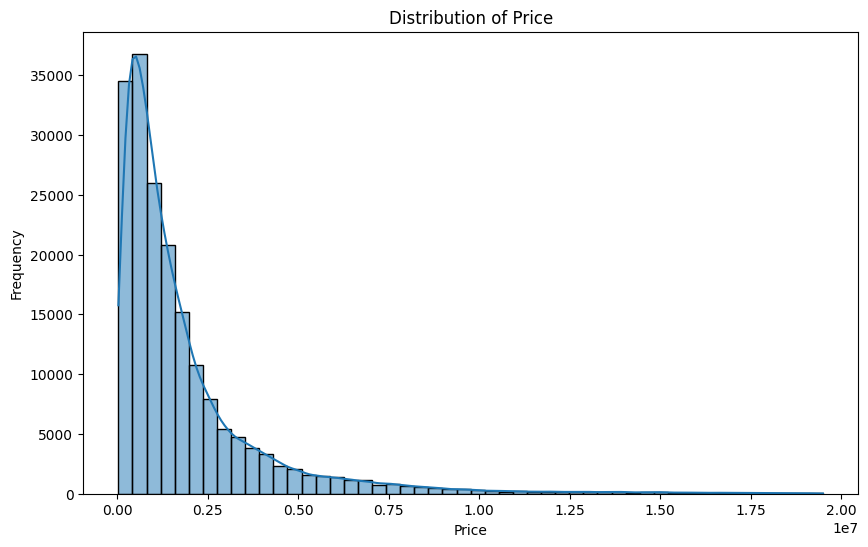

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Box plot of Price to identify outliers')
plt.xlabel('Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


Отсюда понимаем, что такой плохой результат веротяно может быть вызван ассиметрией таргета и хвостами. Более того, у нас есть очень редкие категории title, что тоже может очень плохо сказывться на качестве модели.

Удалим нижний и верхний 1% по цене.

In [20]:
lower_pct = 0.01
upper_pct = 0.99

lower_bound = df['price'].quantile(lower_pct)
upper_bound = df['price'].quantile(upper_pct)

df_trimmed = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].copy()

df_trimmed.reset_index(drop=True, inplace=True)

df = df_trimmed.copy()

Сделаем целевой признак более симметричным логорифмируя его.

In [21]:
X = df[["age", "log_mileage", "engine_capacity", "engine_power", "transmission", "drive_type", "fuel_type", "brand"]]

y = np.log1p(df['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'log_mileage',
                                                   'engine_capacity',
                                                   'engine_power']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['transmission', 'drive_type',
                                                   'fuel_type', 'brand'])])),
                ('stack',
                 StackingRegressor(cv=5,
                                   estimators=[('cat',
                                                <catboost.core.CatBoostRegressor object at 0x78...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('lgb',
                                                LGBMRegressor(random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(random_state=42))],
                                   final_estimator=RidgeCV(), n_jobs=-1,
                                   passthrough=True))])

In [22]:
print_model_loss(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE train: 0.03449115425516684
MAE train: 0.13218065199865434
R2 train: 0.9667197484913289


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE: 0.06450095256093939
MAE: 0.17923637704646242
R2: 0.9374989741658866


In [24]:
import pickle

filename = 'stacking_model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(model, f)